## Modelling
We finally come tom the modelling stage. Here our objective is to test out a variety of linear regression models, and continuously iterate until we find a decent working model. To recap, we already have a baseline model that uses the mean of the training set as the predicted price. Our objective is to **beat** that model, and failing which, to become a monk in Tibet.

There are 4 models we want to test out.
1. Multiple Linear Regression
2. Ridge Regression
3. Lasso Regression
4. ElasticNet Regression - we test this at the end.

In some sense, our MLR will act as our baseline for all 4 regression models, as it is the least complex of all 4. Our basic workflow is as follows:

1. Decide on a set of predictor variables
2. Train MLR, Ridge, and Lasso models on that set of variables.
3. Run these models on the train_val set that we held out before.
4. Compare the RMSE scores for each model, which is what Kaggle uses.
5. Examine, through our Lasso models, which variables zeroed down, and come up with a new set of predictors.
6. Repeat!

For our initial run, we won't run our ElasticNet yet. We'll let Lasso decide which coefficients it thinks are important, and then we'll run a final round with ElasticNet once we've decided on our top 30 predictors. The hope is that with an optimal set of predictors, ElasticNet will be able to strike a balance between Ridge and Lasso for us, giving us the best performance.

Reminder: our baseline model's RMSE validation score is 79511.73. We want to beat this.

#### Import our libraries

In [1]:
# import our libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
%matplotlib inline

# this is just so we can see all our rows at once
pd.set_option('display.max_rows', 120)

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
# import our train_train set
df = pd.read_csv('./datasets/tt_clean_dummy.csv')
df[df.columns[df.isna().sum()>0]].isna().sum() # this is a sanity check for null values

Series([], dtype: float64)

In [4]:
# import our train_val set
df_val = pd.read_csv('./datasets/tv_clean_dummy.csv')
df_val[df_val.columns[df_val.isna().sum()>0]].isna().sum()

Series([], dtype: float64)

### Multiple Linear Regression
Let's start of with our base regression model. For our first run, we're going to throw ALL our variables into our model. This is obviously going to be terribly overfit, but nonetheless, it's a start.

In [5]:
# set our target and predictor variables
y_train = df['SalePrice']
X_train = df.drop(columns = ['SalePrice'])
y_val = df_val['SalePrice']
X_val = df_val.drop(columns = ['SalePrice'])

In [6]:
# create and fit our linear regression model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [7]:
print("LinReg CV mean: {}".format(cross_val_score(lr, X_train, y_train, cv=10, scoring = 'neg_root_mean_squared_error').mean()))
y_preds = lr.predict(X_train)
print("LinReg RMSE on train set: {}".format(mean_squared_error(y_train, y_preds, squared=False)))
y_val_preds = lr.predict(X_val)
print("LinReg RMSE on validation set: {}".format(mean_squared_error(y_val, y_val_preds, squared=False)))

LinReg CV mean: -772769278829210.8
LinReg RMSE on train set: 22544.14434134357
LinReg RMSE on validation set: 2.276001334353644e+17


As we can see, our LinReg generalizes poorly to our validation set. This is expected as our model is severely overfit by using ALL our variables as predictors. However, what is surprising is that it does even worse than our null regression by many times.

### Ridge Regression
We'll run RidgeCV first to find the optimal alpha, then run cross_val_score using a fitted Ridge() model.

In [8]:
def ridge_runner(X_train, X_val, y=y_train, y_val=y_val):
    r_alphas = np.logspace(0,5,200)
    ridge_cv = RidgeCV(alphas=r_alphas, store_cv_values=True)
    ridge_cv.fit(X_train, y)
    # extract optimal alpha
    optimal_ralpha = ridge_cv.alpha_
    # instantiate new model with optimal alpha
    ridge = Ridge(alpha=optimal_ralpha)
    ridge.fit(X_train, y)
    # run cross_val score using the optimal alpha found
    print("Optimal alpha: {}".format(optimal_ralpha))
    print("Ridge CV mean: {}".format(cross_val_score(ridge, X_train, y, cv=10, scoring = 'neg_root_mean_squared_error').mean()))
    # calculate RMSE for train and validation sets
    y_preds = ridge.predict(X_train)
    print("Ridge RMSE on train set: {}".format(mean_squared_error(y, y_preds, squared=False)))
    y_val_preds = ridge.predict(X_val)
    print("Ridge RMSE on validation set: {}".format(mean_squared_error(y_val, y_val_preds, squared=False)))
    return ridge, ridge_cv

In [9]:
ridge, ridge_cv = ridge_runner(X_train, X_val)

Optimal alpha: 12.750512407130135
Ridge CV mean: -24132.029578045003
Ridge RMSE on train set: 21974.646091953142
Ridge RMSE on validation set: 34909.88455085879


The ridge model has already performed significantly better than our linear regression model. However, we see that our ridge model does quite a lot worse on the validation set, which indicates that it is overfitting the train set. This is a case of low bias, but high variance. We will want to reduce this variance so that we can be confident of our model's predictive power on unseen data.

### Lasso Regression
Like for Ridge, we run LassoCV to run the optimal alpha, then we run cross_val_score using a new Lasso model with the optimal alpha. We are also interested here in seeing what variables the Lasso model zeroes out.

In [10]:
def lasso_runner(X_train, X_val, y=y_train, y_val=y_val, l_alphas=None, n_alphas=100, eps=0.001, max_iter=1000):
    if l_alphas is None:
        lasso_cv = LassoCV(n_alphas=n_alphas, eps=eps, max_iter=max_iter)
    else: 
        lasso_cv = LassoCV(alphas=l_alphas)
    lasso_cv.fit(X_train, y)
    # extract the optimal alpha
    optimal_lalpha = lasso_cv.alpha_
    # instantiate a new Lasso model with the alpha we found.
    lasso = Lasso(alpha=optimal_lalpha)
    lasso.fit(X_train, y)
    # run cross_val_score using the optimal alpha found
    print("Optimal alpha: {}".format(optimal_lalpha))
    print("Lasso CV mean: {}".format(cross_val_score(lasso, X_train, y, cv=10, scoring = 'neg_root_mean_squared_error').mean()))
    # calculate RMSE for train and validation sets    
    y_preds = lasso.predict(X_train)
    print("Lasso RMSE on train set: {}".format(mean_squared_error(y, y_preds, squared=False)))    
    y_val_preds = lasso.predict(X_val)
    print("Lasso RMSE on validation set: {}".format(mean_squared_error(y_val, y_val_preds, squared=False)))
    return lasso, lasso_cv

In [11]:
lasso, lasso_cv = lasso_runner(X_train, X_val)

Optimal alpha: 63.41934232018882
Lasso CV mean: -24089.712890508352
Lasso RMSE on train set: 22069.56670453108
Lasso RMSE on validation set: 33338.924014948985


Like the ridge, our lasso also does much better than our linear regresion model. We see the same problems of overfitting here, which is to be expected as we simply threw all our variables at it. Thankfully we should be able to use our Lasso to tell us what variables it felt were important enough to keep.
***
Let's look at what variables our Lasso model retained, i.e. did not set the coefficient to zero for.

In [12]:
# create a table of features and their respective lasso coefficents
coef_table = pd.DataFrame(list(zip(X_train.columns,lasso.coef_)), columns = ['Feature','Coef'])
# sort our table to see our NON-zero coefficients
coef_table[coef_table['Coef']!= 0].sort_values(by='Coef', ascending=False)

,Feature,Coef
104,Neighborhood_StoneBr,3.618283e+04
98,Neighborhood_NridgHt,2.396818e+04
48,Year Built * Gr Liv Area,2.286852e+04
89,Neighborhood_GrnHill,1.947349e+04
97,Neighborhood_NoRidge,1.736192e+04
202,Sale Type_New,1.610440e+04
71,Land Contour_HLS,1.443091e+04
4,Overall Qual,1.347104e+04
15,BsmtFin SF 1,1.166534e+04
138,Exterior 1st_BrkFace,1.154574e+04


In [13]:
# create a column for the absolute value of each coefficient, disregarding sign
coef_table['abs_coef'] = coef_table['Coef'].map(abs)

Lasso has returned us 115 variables with non-zero coefficients. This means it has cut down our variables by almost half. Interestingly, our interaction term of Year Built * Gr Liv area is one of our strongest variables. It should be probable then that there are other interaction terms hiding out there that are strong predictors.
***
Summary table of results:

|Model|Alpha|Train RMSE|Validation RMSE|
|---|---|---|---|
|Lasso with n_alphas=100|63.42|22069.57|33338.92
|Ridge|12.75|21974.65|34909.88
|MLR|na|22544.14|2.28e^17
|Baseline(mean)|na|na|79511.73|

All our models show severe signs of overfitting, with MLR being the worst of all. Even though we get decent results on our train set, our RMSE increases by 50% just by running our models on the validation set. This shows that we need to do something to reduce our models' variance, which is what we will do next by removing predictors.

### Repeat the process
After getting back the useful predictors from our Lasso model, I iterated through all the models again using different methods to pick the top 30 useful predictors each time. This is a summary of my exploration:

1. Selected top 30 predictors by p-values
    - I ran statsmodel.api.OLS and extracted the p-values for all the 115 coefficients
    - After sorting the p-values from small to large, I selected the 30 coefficients with the smallest p-values
    - Obtained validation RMSEs of around 26-27k
2. Selected top 30 predictors by absolute coefficient size 
    - Was an improvement over the first round and obtained validation RMSEs across the board of around 25-26k
3. Selected top 30 predictors with positive coefficients
    - Obtained validation RMSEs of 24k across the board
    - Kaggle scores as you will see later are around 29k

My reasoning for method 1 is that Statsmodel OLS can differentiate between significant and non-significant predictors. Predictors with the smallest p-values should be the most significant, and hence should be able to create a strongly predictive model. While the results weren't bad, they weren't as good as the method 2 and 3. This could be because OLS assumes an unbiased estimator, whereas the coefficients we received back from Lasso were inherently biased. Method 2's reasoning is that the coefficients that Lasso allows to remain large should be coefficients that it feels are most useful for prediction. We see that it is better than method 1, but not as good as method 3. You can see a comparison of these methods in the [Appendix](#Appendix).

Ultimately though, all the validation RMSEs were not too drastically different. This suggests that all 3 methods might be similarly good at producing generalizable models, and differences in scores we see might simply come down to luck based on the dataset we ended up with. If we had gotten different data, or even split the data differently, with different test sizes, or a different random state, we would probably have gotten different results. 

At the end of the day, I should choose my predictors based on what gives me the best validation RMSE score. Since that was done via method 3, the predictors we get from it shall be what we run on our models.

In [14]:
# select the top 30 predictors and save them to a list
X_round2 = list(coef_table.sort_values(by='Coef', ascending=False).head(30)['Feature'])

In [15]:
# subset our existing predictors
X_r2 = X_train[X_round2]
X_val_r2 = X_val[X_round2]

In [16]:
# run our linear regression model
lr = LinearRegression()
lr.fit(X_r2,y_train)
print("LinReg CV mean: {}".format(cross_val_score(lr, X_r2, y_train, cv=10, scoring = 'neg_root_mean_squared_error').mean()))
y_preds = lr.predict(X_r2)
print("LinReg RMSE on train set: {}".format(mean_squared_error(y_train, y_preds, squared=False)))
y_val_preds = lr.predict(X_val_r2)
print("LinReg RMSE on validation set: {}".format(mean_squared_error(y_val, y_val_preds, squared=False)))

LinReg CV mean: -24454.779484398507
LinReg RMSE on train set: 23712.354396000053
LinReg RMSE on validation set: 24625.626067014233


Not bad. Our linear regression model has performed **significantly** better than the first time round by removing many of the unimportant, noisy variables. We also see that our scores on our validation set are no longer way off from our train set, indicating that we have significantly reduced overfitting.

In [17]:
# run our ridge model
ridge, ridge_cv = ridge_runner(X_r2, X_val_r2)

Optimal alpha: 2.1214517849106302
Ridge CV mean: -24433.518507996312
Ridge RMSE on train set: 23819.91666214308
Ridge RMSE on validation set: 24565.27223474124


As could be expected, our Ridge also does better than the first round, but it is now not noticeably that much better than our linear regression model. This COULD indicate that our predictors are doing quite a good job by themselves, and we can see that indeed our alpha, or strength of penalty, decreased from 12.75 to 2.12 this time, meaning that ridge did not feel the need to penalize our coefficients as much this time round.

#### Side note:
For context, when running LassoCV with default eps and n_alphas arguments, the best alpha returned was the smallest alpha out of the 100 it tests. This suggests that it actually wants to go lower. We thus set the eps to a smaller value, letting LassoCV explore a larger range of alphas. When it settles on an alpha that is neither the max or minimum alpha in its range, we finetune the alpha selection by iterating over a small range around the alpha given, using small steps in between. This helps us select the most accurate alpha possible.

In [19]:
# we're going to run LassoCV with a large range of alphas
lasso, lasso_cv = lasso_runner(X_r2, X_val_r2, eps=0.0001)
lasso_cv.alphas_

Optimal alpha: 21.255643584114274
Lasso CV mean: -24456.628262994396
Lasso RMSE on train set: 23734.657905023734
Lasso RMSE on validation set: 24500.184792224463


array([6.34193423e+04, 5.77853427e+04, 5.26518522e+04, 4.79744067e+04,
       4.37124927e+04, 3.98291953e+04, 3.62908793e+04, 3.30668976e+04,
       3.01293256e+04, 2.74527194e+04, 2.50138954e+04, 2.27917299e+04,
       2.07669754e+04, 1.89220946e+04, 1.72411078e+04, 1.57094553e+04,
       1.43138706e+04, 1.30422658e+04, 1.18836269e+04, 1.08279182e+04,
       9.86599579e+03, 8.98952792e+03, 8.19092303e+03, 7.46326401e+03,
       6.80024820e+03, 6.19613289e+03, 5.64568552e+03, 5.14413838e+03,
       4.68714731e+03, 4.27075406e+03, 3.89135204e+03, 3.54565505e+03,
       3.23066883e+03, 2.94366511e+03, 2.68215802e+03, 2.44388249e+03,
       2.22677471e+03, 2.02895418e+03, 1.84870748e+03, 1.68447340e+03,
       1.53482943e+03, 1.39847941e+03, 1.27424236e+03, 1.16104218e+03,
       1.05789839e+03, 9.63917613e+02, 8.78285829e+02, 8.00261336e+02,
       7.29168325e+02, 6.64391020e+02, 6.05368353e+02, 5.51589097e+02,
       5.02587442e+02, 4.57938959e+02, 4.17256924e+02, 3.80188969e+02,
      

In [20]:
# lasso_cv2 gave us an alpha of 21.26, which is not the smallest alpha tested. 
# this tells us that this alpha is near the minima for cv means. we finetune this alpha.
l_alphas = l_alphas = np.arange(20, 24, 0.001)
lasso, lasso_cv = lasso_runner(X_r2, X_val_r2,l_alphas = l_alphas)
# save our finetuned alpha
optimal_lalpha = lasso_cv.alpha_;

Optimal alpha: 21.5540000000019
Lasso CV mean: -24456.775019057943
Lasso RMSE on train set: 23735.287596709277
Lasso RMSE on validation set: 24499.186358450745


As you can see, by finetuning the alpha given to us by LassoCV, we can improve our validation scores a tiny bit. The important thing to ensure is that LassoCV is searching over a large enough range of alphas. If LassoCV returns either the biggest or smallest alpha out of the entire range it searches, we know that we need to extend our search in that respective direction.

#### ElasticNet
Let's now run an ElasticNetCV to see if how it regularizes our predictors differently.

In [21]:
# these ratios were obtained after a few iterations
l1_ratios = [0.98,0.985,0.99,0.995,1]

In [22]:
def enet_runner(X_train, X_val, y=y_train, y_val=y_val, l1_ratios=l1_ratios, enet_alphas=None, n_alphas=100, eps=0.001):
    if enet_alphas is None:
        enet_cv = ElasticNetCV(n_alphas=n_alphas, l1_ratio=l1_ratios, eps=eps)
    else: 
        enet_cv = ElasticNetCV(alphas=enet_alphas, l1_ratio=l1_ratios)
    enet_cv.fit(X_train, y)
    # extract optimal alpha and l1_ratio
    optimal_lalpha = enet_cv.alpha_
    optimal_l1 = enet_cv.l1_ratio_
    # instantiate new model with optimal alpha
    enet = ElasticNet(alpha=optimal_lalpha, l1_ratio=optimal_l1)
    enet.fit(X_train, y)
    # run cross_val score using the optimal alpha found
    print("Optimal alpha: {}".format(optimal_lalpha))
    print("Optimal l1 ratio: {}".format(optimal_l1))
    print("Enet CV mean: {}".format(cross_val_score(enet, X_train, y, cv=10, scoring = 'neg_root_mean_squared_error').mean()))
    y_preds = ridge.predict(X_train)
    print("Enet RMSE on train set: {}".format(mean_squared_error(y, y_preds, squared=False)))
    y_val_preds = ridge.predict(X_val)
    print("Enet RMSE on validation set: {}".format(mean_squared_error(y_val, y_val_preds, squared=False)))
    return enet, enet_cv

In [23]:
enet, enet_cv = enet_runner(X_r2, X_val_r2, l1_ratios=l1_ratios, eps=0.0001)

Optimal alpha: 21.255643584114274
Optimal l1 ratio: 1.0
Enet CV mean: -24456.628262994396
Enet RMSE on train set: 23819.91666214308
Enet RMSE on validation set: 24565.27223474124


Our ElasticNetCV chose an l1 ratio of 1.0, meaning it opted to run purely on Lasso regularization. As such, we can disregard the use of this model and simply use our Lasso model.

### Visualize our predictions
We'll plot a graph of our predicted vs actual values of SalePrice for our validation set, using the best model we got so far, our Lasso with alpha=21.55

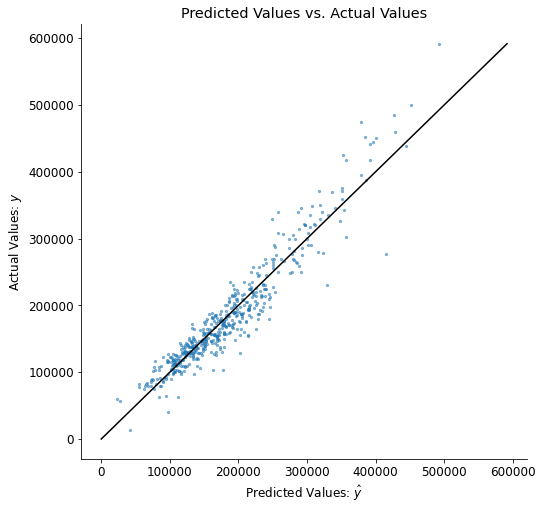

In [24]:
y_preds = lasso.predict(X_val_r2)
plt.figure(figsize=(8,8))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_preds, y_val, s=5, alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(y_val)],
         [0, np.max(y_val)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$")
plt.ylabel("Actual Values: $y$")
plt.title('Predicted Values vs. Actual Values');

All things considered, our predictions do seem to cluster around the regression line quite well. We notice that as actual values of sale price increase, our predictions start deviating further more. The inaccuracy of our predictions at that range of sale prices might be due to the fact that we do not have as much data on ultra expensive properties. Looking above, we can see that there are relatively very few houses over the 400k price mark, whereas there are hundreds and hundreds below the 200k mark. To improve our model for predictions \\$300k and above we would like to have more data to train on.

## Run our 2nd round models on our test data to submit to Kaggle
Let's now bring in our test data to run these models on. We use the 30 predictors that we obtained above.

In [25]:
# read in our test set.
df_test = pd.read_csv('./datasets/test_clean_dummy.csv')
# unfortunately, when we did our preprocessing in the previous notebook, we ended up deleted our ID column.
# we'll just replace the Id column by reading in the base test set.
basetest = pd.read_csv('./datasets/test.csv')
# and pull over the Id column
df_test['Id'] = basetest['Id']

Let's start our best model, Lasso

In [26]:
X_test = df_test[X_round2]

In [27]:
# create our predictions using our finetuned alpha
test_preds = lasso.predict(X_test)
# create a csv to submit to kaggle
kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
                             'SalePrice': test_preds})
kaggle_lasso.to_csv('./datasets/kaggle_lasso_ownalpha.csv',index=False)

Run our Ridge model

In [28]:
test_preds = ridge.predict(X_test)
kaggle_ridge = pd.DataFrame({'ID':df_test['Id'],
                             'SalePrice': test_preds})
kaggle_ridge.to_csv('./datasets/kaggle_ridge2.csv',index=False)

Run our MLR model just for good measure

In [29]:
test_preds = lr.predict(X_test)
kaggle_mlr = pd.DataFrame({'ID':df_test['Id'],
                             'SalePrice': test_preds})
kaggle_mlr.to_csv('./datasets/kaggle_mlr.csv',index=False)

## Model results
These are our new results:

|Model|Alpha|Train RMSE|Validation RMSE|Kaggle RMSE|
|---|---|---|---|---|
|Lasso|21.55|23735.29|24499.2|29382.85|
|Ridge|2.12|23819.92|24565.27|29357.91|
|MLR|na|23712.35|24625.63|29457.31|
|Baseline(mean)|na|na|79511.73|83689.59|

Interestingly, our Ridge does very slightly better than our Lasso. This might simply be due us having a small dataset, so the results might just be down to luck. But the most important improvement is that all 3 types of models are no longer severely overfitting the data, as shown by the small difference in RMSE between our train and validation scores. This shows that we have succeeded in improving the generalizability of our models, although there is room for improvement as we can see that our Kaggle scores are not doing as well as our validation scores.

### Retraining our best model on the entire training set

At the beginning, we split our data into training and validation sets to facilitate our testing. Now that it's time to ship out our best model to production, it's time to retrain our model on our original unsplit dataset. Having more data should allow our model to make better predictions.

In the real world, we would not have had access to Kaggle's results. As such, based on our validation scores, our Lasso with alpha=21.55 performed the best with an RMSE of 24499.2. We'll train this model on our original train set.

In [30]:
# rejoin our train and validation sets together and select the 30 best predictors
y_full = pd.concat([y_train, y_val])
X_full = pd.concat([X_train, X_val])
X_full_30 = X_full[X_round2]

In [31]:
# we instantiate a new lasso model and fit it on our new data
lasso = Lasso(alpha = optimal_lalpha)
lasso.fit(X_full_30, y_full)

Lasso(alpha=21.5540000000019)

In [32]:
# create our predictions using alpha=21.55
test_preds = lasso.predict(X_test)
# create a csv to submit to kaggle
kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
                             'SalePrice': test_preds})
kaggle_lasso.to_csv('./datasets/kaggle_lasso_fulltrain.csv',index=False)

**Our final Kaggle score is 29210.85**. This is marginally better than our previous Lasso score that we trained on our split training set. The slight improvement can be attributed to the fact that our final model was retrained on the full training data we received, ~2000 rows, vs the ~1500 rows we've been using throughout due to our train_test_split. However, we should still note that our Kaggle score is some distance away from our validation RMSE; as such we know that there is still room for improvement in our model to reduce overfitting.

## Discussion
At the beginning of this project, we set out to build a model to predict house prices based on a set of predictor variables. After much iteration and evaluation of Multiple Linear Regression, Ridge, Lasso, and ElasticNet models, we found that the Lasso model performed the best. As the Lasso model is a biased estimator, we are unable to make inferences about the underlying predictor variables because inference requires the use of an **unbiased** linear estimator that fulfills the 4 LINE assumptions:
- Linear relationship between predictors and target
- Independence of residuals
- Normality of residuals
- Equality of variance of residuals

Nonetheless, as our goal was to build a predictive model, we should be satisfied with our end results. 

Let's look at the final 30 predictors we used.

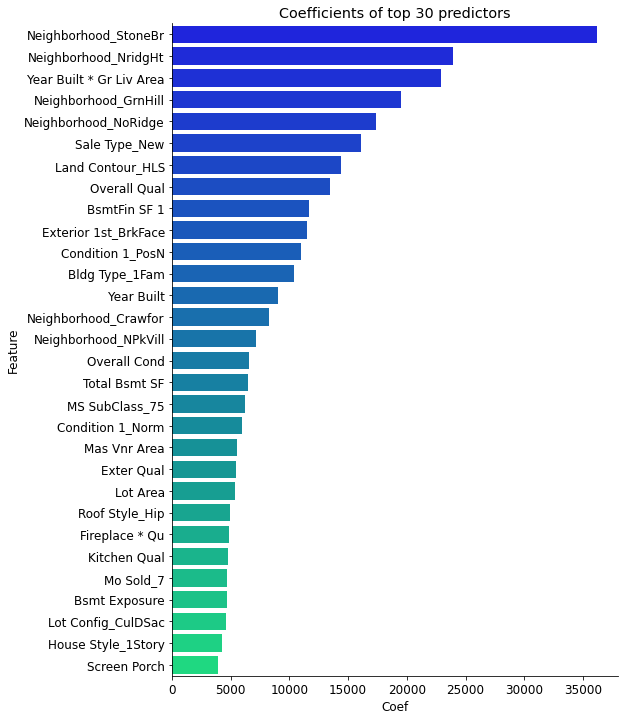

In [33]:
top_30_idx = coef_table.sort_values(by='Coef', ascending=False).head(30)['Feature'].index
fig, ax = plt.subplots(figsize=(8,12))
g = sns.barplot(data = coef_table.loc[top_30_idx], 
                x='Coef', y='Feature', ax=ax, palette='winter')
g.set_title('Coefficients of top 30 predictors');

Let's interpret these results. What our model says is that for a unit increase in our predictor, the SalePrice for that house will increase by the value of the coefficient. As our neighborhood variables are binary, essentially the model says, for example, "if your house is in Stone Brook, your sale price will increase by \\$36182." When interpreting the coefficient for our interaction term we have to be careful to not think that a unit increase in either Year Built or above ground living area will lead to a \\$23968 increase in sale price. Rather, the interaction term as a whole needs to increase by 1 unit for sale price to increase by \\$23968.

The top 5 predictors we got from Lasso include 4 binary Neighborhood variables. This shows that the most important predictor for housing prices remains the neighborhood the house is in. Locally, we know this to be true if we think about District 11 houses, or anything in the Bukit Timah area. If you tell someone that you're buying a house there, people already have a rough idea how much your house is going to cost. This model suggests that knowing the neighborhood that a house is located already allows us to make preliminary predictions of sale prices.

Another important class of predictors are square footage related variables. We see that basement size, lot size, and the interaction between above ground living area and year built feature prominently in our list. This is not unexpected. After all, one of the first things people ask about a house would be "How big is it?" We also see quality related predictors being important. This is also a reasonable assumption, as well-built houses with good material and workmanship are likely to last longer and require less rebuilding or fixing in the future, and as such fairly command a higher premium.

A final note is that because we used a Lasso model, we are producing biased estimates of the true coefficients of these variables. Recall that Lasso regularization attempts to bias coefficients towards 0 in order to reduce prediction error. As such, we cannot infer from our Lasso coefficients what the true coefficients will be. At the same time, we are also unable to infer a variable's significance in predicting sale price. 

A meta observation to make is that while we only engineered 2 interaction terms, BOTH these terms ended up being chosen by our Lasso model. My intuition is that much of the variation in house prices could be explained by even more of these interaction terms, and apart from simply gathering data on more variables, a logical next step would be to comprehensively explore existing interactions between our variables to see if our hypothesis holds true.

## Recommendations
Based on our model we can recommend a few concrete actions to different groups of market participants to consider based on their objectives. **For buyers** for whom location is not a big issue, we recommend looking at properties located outside neighborhoods such as Stone Brook and Northridge Heights. You would be able to get house of significantly better quality and size for the same price as a property in one of those expensive neighborhoods. **For sellers** looking to increase the value of their house, we recommend either expanding the liveable area of their property, or to invest in upgrading the quality and finish of their house. **For developers** looking to build their next profitable project, we recommend developing them within neighborhoods like Stone Brook and Northridge Heights.

As far as improving our model goes, there are some further actions we can take. Firstly, as mentioned above, we noticed that interaction effects between our existing variables may help explain more of the variation in housing prices. Given more time, we can exhaustively examine all first-order interactions and run Recursive Feature Elimination to select important interaction terms. After all, this is real-world data, and we should not expect everything to be neatly explained solely by main effects.

Secondly, we could consider creating predictive models for each neighborhood. Seeing as how neighborhood features heavily in our top 30 predictors, it's possible that housing prices in different neighborhoods are differently influenced by our other predictors. What may be important in one neighborhood may not be important in another. As such, if one has a unique model for each neighborhood, it might be possible to capture the variation inherent in each neighborhood, allowing you to more accurately predict housing prices.

Thirdly, for this project we wanted to keep our model complexity low, hence we capped our predictors at 30. However, if are seeking to maximize the predictive power of our model, we can experiment with changing the model's complexity by adding or taking away predictors. As shown in the [Appendix](#Appendix), combinations of 45 and 60 predictors appear to reduce our validation RMSE even further. More iterations can be done to find out what is the optimal balance between bias and variance. As we recall, the original 115 predictors given by Lasso resulted in a train score of 22k but a validation score of 33k. The optimal balance thus likely lies somewhere between 60 and 115 predictors.


### Appendix
These are some extra models I ran to test out certain things. I tested either using top positive coefficients or top absolute coefficients, and I test these out with 30, 45, or 60 predictors. You can observe that increasing model complexity appears to improve scores for now.

In [34]:
# top 30 asbolute coefficient 
top_30_abs = list(coef_table[coef_table['Coef']!=0].sort_values(by='abs_coef', ascending=False).head(30)['Feature'])
l_alphas = l_alphas = np.arange(50, 55, 0.001)
lasso3, lasso_cv3 = lasso_runner(X_train[top_30_abs], X_val[top_30_abs],n_alphas=200, eps=0.0001)
# test_preds = lasso3.predict(df_test[top_30_abs])
# # create a csv to submit to kaggle
# kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
#                              'SalePrice': test_preds})
# kaggle_lasso.to_csv('./datasets/kaggle_lasso_30_abs.csv',index=False)

Optimal alpha: 53.314439712003164
Lasso CV mean: -25336.76240182651
Lasso RMSE on train set: 24578.782252618807
Lasso RMSE on validation set: 25652.600596535063


In [35]:
# top 45 positive coefficients
top_45_pos = list(coef_table[coef_table['Coef']!=0].sort_values(by='Coef', ascending=False).head(45)['Feature'])
l_alphas = l_alphas = np.arange(9, 11, 0.001)
lasso3, lasso_cv3 = lasso_runner(X_train[top_45_pos], X_val[top_45_pos],n_alphas=200, eps=0.0001)
# test_preds = lasso3.predict(df_test[top_45_pos])
# # create a csv to submit to kaggle
# kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
#                              'SalePrice': test_preds})
# kaggle_lasso.to_csv('./datasets/kaggle_lasso_45.csv',index=False)

Optimal alpha: 10.551817265617263
Lasso CV mean: -24118.39057722564
Lasso RMSE on train set: 23092.067818102507
Lasso RMSE on validation set: 23575.942824855232


In [36]:
# top 45 absolute coefficients
top_45_abs = list(coef_table[coef_table['Coef']!=0].sort_values(by='abs_coef', ascending=False).head(45)['Feature'])
l_alphas = l_alphas = np.arange(26,30, 0.001)
lasso4, lasso_cv4 = lasso_runner(X_train[top_45_abs], X_val[top_45_abs],n_alphas=200, eps=0.0001)
# test_preds = lasso4.predict(df_test[top_45_abs])
# # create a csv to submit to kaggle
# kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
#                              'SalePrice': test_preds})
# kaggle_lasso.to_csv('./datasets/kaggle_lasso_45_abs.csv',index=False)

Optimal alpha: 27.8893128686867
Lasso CV mean: -24035.36614897709
Lasso RMSE on train set: 22933.63610544759
Lasso RMSE on validation set: 24042.568420903033


In [38]:
# top 60 positive coefficients
top_60 = list(coef_table[coef_table['Coef']!=0].sort_values(by='Coef', ascending=False).head(60)['Feature'])
lasso4, lasso_cv4 = lasso_runner(X_train[top_60], X_val[top_60], n_alphas=200, eps=0.0001)
# test_preds = lasso4.predict(df_test[top_60])
# # create a csv to submit to kaggle
# kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
#                              'SalePrice': test_preds})
# kaggle_lasso.to_csv('./datasets/kaggle_lasso_60.csv',index=False)

Optimal alpha: 12.697823077378194
Lasso CV mean: -23831.76949917916
Lasso RMSE on train set: 22482.287246065916
Lasso RMSE on validation set: 22632.72311728072


In [37]:
# top 60 absolute coefficients
top_60_abs = list(coef_table[coef_table['Coef']!=0].sort_values(by='abs_coef', ascending=False).head(60)['Feature'])
lasso4, lasso_cv4 = lasso_runner(X_train[top_60_abs], X_val[top_60_abs], n_alphas=200, eps=0.0001)
# test_preds = lasso4.predict(df_test[top_60_abs])
# # create a csv to submit to kaggle
# kaggle_lasso = pd.DataFrame({'ID':df_test['Id'],
#                              'SalePrice': test_preds})
# kaggle_lasso.to_csv('./datasets/kaggle_lasso_60_abs.csv',index=False)

Optimal alpha: 6.341934232018883
Lasso CV mean: -23687.890139315532
Lasso RMSE on train set: 22329.00019110239
Lasso RMSE on validation set: 23356.31070967787
